# 5. Spectrogram classification 모델

# 1차원 데이터

## 1. 데이터 처리와 분류
라벨 데이터 처리하기   
sklearn의 train_test_split함수를 이용하여 train, test 분리

### 아날로그 신호의 표본화(Sampling)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

#### 사인함수 그려보기

In [ ]:
plt.plot(y[:41])
plt.show()

#### 1사이클 동안 나타나는 이산시간 연속크기 신호 출력

In [ ]:
plt.stem(y[:41])
plt.show()

In [ ]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)


In [ ]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

### 라벨 데이터 처리하기

In [ ]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

In [ ]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

### sklearn 의 train_test_split 함수를 이용하여 train, test분리

In [ ]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

In [ ]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

## 2. 학습을 위한 하이퍼파라미터 설정

In [ ]:
batch_size = 32
max_epochs = 1

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

## 3. 데이터셋 구성

In [ ]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

In [ ]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

## 4. 1,2차원 Spectrogram 데이터를 처리하는 모델 구성

In [ ]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

## 5_1D. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

### loss

In [ ]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

### Training

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

In [ ]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

### 학습 결과 Plot

In [ ]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6_1D. Test dataset을 이용해서 모델의 성능을 평가

### Evaluation

In [ ]:
model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

Model Test

In [ ]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

# 2차원 데이터

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)


In [2]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [3]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

## 1. Spectrogram형태변환

In [4]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [10]:
# 위에서 뽑았던 sample data
spec = []
for wav in speech_data["wav_vals"]:
    spec.append(wav2spec(wav))
spec = np.array(spec)
#print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Spectrogram shape :  (50620, 130, 126)


### sklearn 의 train_test_split 함수를 이용하여 train, test분리

In [11]:
from sklearn.model_selection import train_test_split

sr1 = 130
sr2 = 126
train_spec, test_spec, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec)

#train_spec = train_spec.reshape([-1, sr1, sr2, 1]) # add channel for CNN
#test_spec = test_spec.reshape([-1, sr1, sr2, 1])
print("✅")

[[[4.60092491e-03 2.71905819e-03 7.70712039e-04 ... 1.80312854e-04
   2.61461874e-03 4.15811036e-03]
  [4.48347768e-03 2.18441966e-03 1.87755295e-03 ... 1.33455580e-03
   1.64828496e-03 4.76078736e-03]
  [5.88892493e-03 3.28224618e-03 1.49859418e-03 ... 4.16956749e-03
   5.00159897e-03 6.24230318e-03]
  ...
  [2.80520362e-05 7.59626710e-06 2.45754327e-05 ... 1.14698960e-05
   9.31594477e-05 1.82606585e-04]
  [2.97585084e-05 1.70707590e-05 4.31881244e-06 ... 5.03811179e-06
   9.20936072e-05 1.77745984e-04]
  [3.31375595e-05 1.89937273e-05 1.57822001e-06 ... 9.22443803e-07
   8.86536873e-05 1.73474429e-04]]

 [[7.94562511e-03 2.26452525e-04 8.14756751e-03 ... 3.14701209e-03
   1.01803774e-02 1.93751995e-02]
  [1.23067619e-02 8.90201516e-03 5.05672069e-03 ... 2.92237708e-03
   1.01849474e-02 1.61517542e-02]
  [1.46610457e-02 9.09839571e-03 3.54364445e-03 ... 7.97941815e-03
   6.39510062e-03 9.78147238e-03]
  ...
  [4.64612432e-03 2.04446260e-03 5.72959427e-04 ... 5.86317154e-04
   2.28219

In [12]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [13]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj48/aiffel/speech_recognition/models/wav'

In [14]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


## 4. 1,2차원 Spectrogram 데이터를 처리하는 모델 구성

In [15]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# 랜덤시드 고정시키기
np.random.seed(3)

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr1, sr2, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

## 5_2D. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

### loss

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### Training

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [19]:
del speech_data
del spec

In [20]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/5
1423/1423 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.7569
Epoch 00001: val_loss improved from inf to 0.33423, saving model to /home/aiffel-dj48/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 198s 139ms/step - loss: 0.7195 - accuracy: 0.7569 - val_loss: 0.3342 - val_accuracy: 0.8910
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9236
Epoch 00002: val_loss improved from 0.33423 to 0.18891, saving model to /home/aiffel-dj48/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 198s 139ms/step - loss: 0.2375 - accuracy: 0.9236 - val_loss: 0.1889 - val_accuracy: 0.9399
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9473
Epoch 00003: val_loss improved from 0.18891 to 0.17272, saving model to /home/aiffel-dj48/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 198s 139ms/st

### 학습 결과 Plot

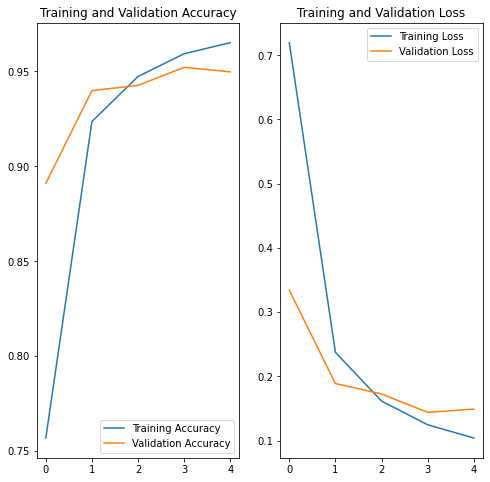

✅


In [21]:
import matplotlib.pyplot as plt

acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6_2D. Test dataset을 이용해서 모델의 성능을 평가

### Evaluation

In [22]:
model_spec.load_weights(checkpoint_dir)
results = model_spec.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 29s 182ms/step - loss: 0.1440 - accuracy: 0.9522
loss value: 0.144
accuracy value: 95.2193%
✅


Model Test

In [23]:
import IPython.display as ipd
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126), rate=8000)

label :  unknown


In [24]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: silence(Incorrect!)
✅


---

dddasdsa


In [25]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

NameError: name 'spec' is not defined